## Counting objects with YOLO8

In this exercise, we will count a particular object in real-time using [YOLOv8](https://docs.ultralytics.com/models/yolov8/) object detection model. With this exercise, we will see how we can effectivily monitor not only static objects but also the objects as they move within a bounding box. We will also see how we can change the object that we want to count for different scenarios.

This exercise is divided into steps. We start with the first step of installation and we end with the last step which is the excecution. The execution is the step will all us to tell the system which object we would like to use for object counting.

## Installation
The first step is to run the following install steps.
Click on the Play icon to the left of the cell below to install opencv-python, pyyaml and openvino.

## Import libraries
The next step is the import of the necessary libraries.
Click on the Play icon to the left of the cell below to importing the required libraries.

In [1]:
%pip install openvino
%pip install "ultralytics==8.2.24"
import platform
from ultralytics import YOLO
from pathlib import Path
# Inference function
from ultralytics import YOLO
from ultralytics.solutions import ObjectCounter
import cv2
import time
import collections
import numpy as np
from IPython import display
import torch
import openvino as ov
#import ipywidgets as widgets
import matplotlib.pyplot as plt
from pathlib import Path

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\munabeel\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\munabeel\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## Initializing the model

Our next step is to initialize the model. Key points about this steps are :
- Detection model name is declared. In our case that is "yolov8n"
- Detection model path is set.
- Label map is loaded. The label map tells us what class of objects we can use to accomplish the counting of a particular object. For example, we can use people as class of object, or apples. Label map is the list of all those classes of objects.

Click on the Play icon to the left of the cell below to initialize the model.

In [2]:

models_dir = Path("./models")
models_dir.mkdir(exist_ok=True)

DET_MODEL_NAME = "yolov8n"

det_model = YOLO(models_dir / f"{DET_MODEL_NAME}.pt")
label_map = det_model.model.names

# Need to make en empty call to initialize the model
res = det_model()
det_model_path = models_dir / f"{DET_MODEL_NAME}_openvino_model/{DET_MODEL_NAME}.xml"
if not det_model_path.exists():
    det_model.export(format="openvino", dynamic=True, half=True)


C:\Users\munabeel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\ultralytics\nn\tasks.py:732: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any iss

WARNING  'source' is missing. Using 'source=C:\Users\munabeel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\ultralytics\assets'.

image 1/2 C:\Users\munabeel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\ultralytics\assets\bus.jpg: 640x480 4 persons, 1 bus, 1 stop sign, 697.9ms
image 2/2 C:\Users\munabeel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\ultralytics\assets\zidane.jpg: 384x640 2 persons, 1 tie, 387.5ms
Speed: 19.3ms preprocess, 542.7ms inference, 12905.6ms postprocess per image at shape (1, 3, 384, 640)


## Setting up of helper functions
This excercise is designed to explain each part and having an opportunity to see how each part is defined, the goal of this step is to review and excecute the helper function that make this work. There are two helper functions that we will execute in this step. The first helper function shows how the box around the detected object is defined, what color is used and thickness of the box. The second helper function is about the points. This is used when object is on the move. For example a person.

Click on the Play icon to the left of the cell below to setup the helper functions

In [3]:
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2))

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    

## Setting up the inferencing function
The inferencing function is the core of the this excercise. This function takes three parameters. These paramters are:
- Source: This parameter tells the inferencing function which video feed to use as the source.
- DeviceType: This parameter is related to the device type to use for inferencing. In our example, we are going to use "CPU" as the devices type. Other example of this parater is "GPU" which we are not using in this exercise.
- Object to count - This parameter tells what object to use for counting. Right now we have limited to three objecs, which are "apple", "banana" and "person". If we need more obects, we can definately add more logic to add more objects.

 Now, let us take a look at what is happening in the function:
 - Initializing of the OpenVino.
 - Model is loaded in accordance with the giving "deviceType".
 - Video capture is initialized.
 - Object counting is initiated.
 - As each frame is received after object detection, the following annotations are added to output frame:
    - Text annoations
    - Buonding box
    - Points (incase object is in motion)

Click on the Play icon to the left of the cell below to setup the inferencing function


In [4]:
%pip install "ultralytics==8.2.24" opencv-python pyyaml openvino
def run_inference(source, deviceType, objectToCount):
    core = ov.Core()
   
    det_ov_model = core.read_model(det_model_path)
    ov_config = {}

    compiled_model = core.compile_model(det_ov_model, deviceType, ov_config)

    def infer(*args):
        result = compiled_model(args)
        return torch.from_numpy(result[0])

    # Use openVINO as inference engine
    det_model.predictor.inference = infer
    det_model.predictor.model.pt = False

    try:
        cap = cv2.VideoCapture(source)
        assert cap.isOpened(), "Error reading video file"
        # line_points = [(0, 300), (1080, 300)]  
        # line_points = [(0, 1080, 1080, 0, 0), (300, 300,0,0, 300)]  # line or region points
        line_points = [(0, 600), (800, 600),(800, 0),(0,0),(0,600)]  # line or region points

        classes_to_count = [0]  # person is class 0 in the COCO dataset, 46 is banana and 47 is apples.
        if(objectToCount == "person"):
            classes_to_count == [0]
        if(objectToCount == "banana"):
            classes_to_count = [46]
        if(objectToCount == "apple"):
           classes_to_count = [47]

           
        # Init Object Counter
        counter = ObjectCounter(
            view_img=False, reg_pts=line_points, classes_names=det_model.names, draw_tracks=True, line_thickness=1, view_in_counts=False, view_out_counts=False
        )
        # Processing time
        processing_times = collections.deque(maxlen=200)

        while cap.isOpened():
            success, frame = cap.read()
            if not success:
                print("Video frame is empty or video processing has been successfully completed.")
                break

            start_time = time.time()
            tracks = det_model.track(frame, persist=True, show=False, classes=classes_to_count, verbose=False)
            frame = counter.start_counting(frame, tracks)
            stop_time = time.time()

            processing_times.append(stop_time - start_time)

            # Mean processing time [ms].
            _, f_width = frame.shape[:2]
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            cv2.putText(
                img=frame,
                text=f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)",
                org=(20, 40),
                fontFace=cv2.FONT_HERSHEY_COMPLEX,
                fontScale=f_width / 1000,
                color=(0, 0, 255),
                thickness=2,
                lineType=cv2.LINE_AA,
            )

            # Get the counts. Counts are getting as 'OUT'
            # Modify this logic accordingly
            counts = counter.out_counts

            # Define the text to display
            text = f"Count: {counts}"
            fontFace = cv2.FONT_HERSHEY_COMPLEX
            fontScale = 0.75  # Adjust scale as needed
            thickness = 2

            # Calculate the size of the text box
            (text_width, text_height), _ = cv2.getTextSize(text, fontFace, fontScale, thickness)

            # Define the upper right corner for the text
            top_right_corner = (frame.shape[1] - text_width - 20, 40)
            # Draw the count of "OUT" on the frame
            cv2.putText(
                img=frame,
                text=text,
                org=(top_right_corner[0], top_right_corner[1]),
                fontFace=fontFace,
                fontScale=fontScale,
                color=(0, 0, 255),
                thickness=thickness,
                lineType=cv2.LINE_AA,
            )

            # Show the frame
            _, encoded_img = cv2.imencode(ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100])
            # Create an IPython image.
            i = display.Image(data=encoded_img)
            # Display the image in this notebook.          
            display.clear_output(wait=True)
            display.display(i)
    except KeyboardInterrupt:
        print("Interrupted")

    cap.release()
    cv2.destroyAllWindows()

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\munabeel\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## Let us choose what we want to track
For this step, assign one of three values to objectToCount variable below. The three options are: person, apple and banana.

- To accomplish this, enter the value for "objectToCount" variable in the below cell.
- Once "objectToCount" variable is set, click on the play icon to the left of the cell below to execute assigning of the source vide step.

In [5]:
objectToCount = ""   # "person", "apple" or "banana"

## Let us choose the video source.

For this step, provide a URL of a Video feed that would be used as the source video for inference.

- To accomplish this, enter the value for "sourceVideo" variable in the below cell.
- Once "sourceVideo" variable is set, click on the play icon to the left of the cell below to execute assigning of the source vide step.


In [6]:
# Available video 1: https://download.microsoft.com/download/caaf80b6-2394-4fbc-8430-8b41a3206c64/people-are-pushing-carts-along.mp4
# Available video 2: https://download.microsoft.com/download/a0ac5d61-60b6-4037-9555-ba5acefeb0c8/people-near-shop-counter-fruit.mp4

sourceVideo = ""

## Execution
This is the final step of the exercise. In this step, the inferening function that was defined in the previous step, is called and the output result is shown.
As mentioned previously, the inferencing function receives the information about the source of the video, the deviceType (in our case it is "CPU") and the object to count information from this execution step.

Click on the Play icon to the left of the cell below to execute the final step.

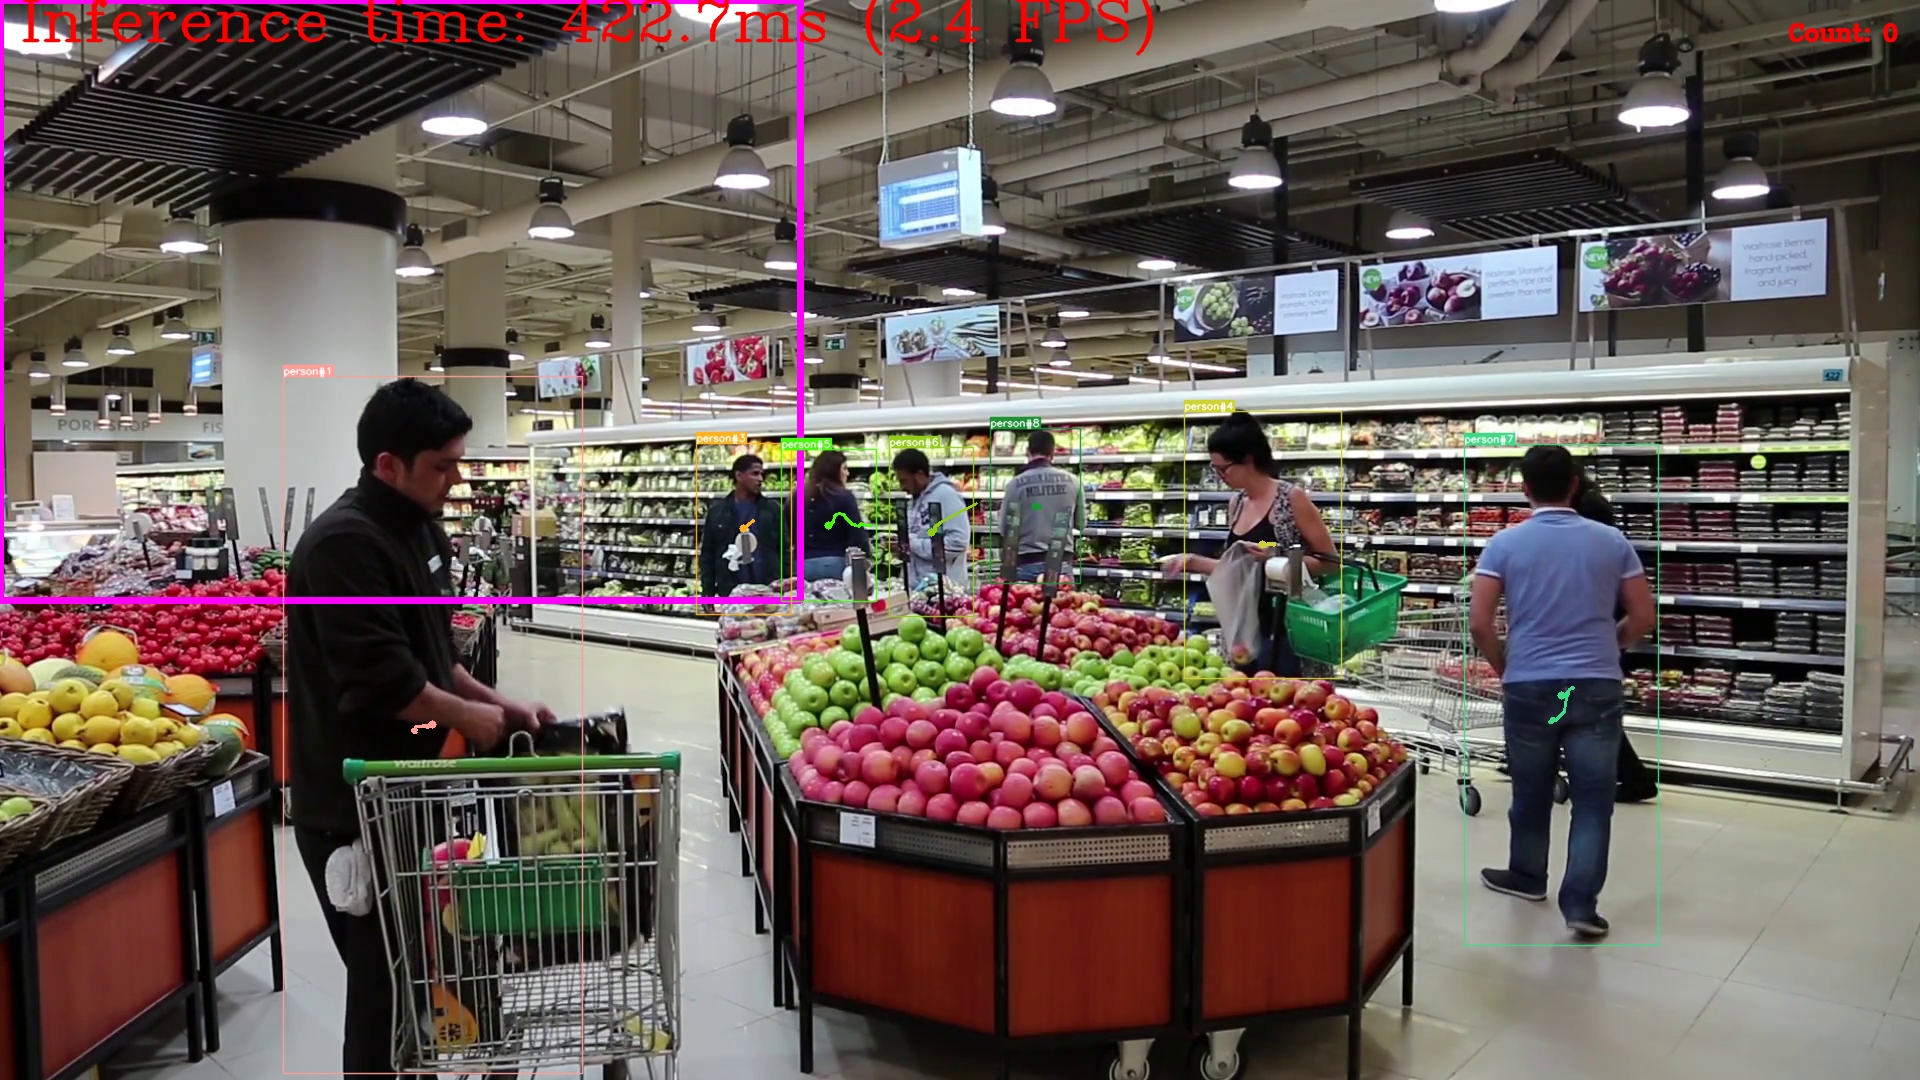

In [ ]:
core = ov.Core()
deviceType = "CPU"

if objectToCount == "":
    print("Missing objectToCount")
    print("Adding default value")
    objectToCount = "person"

if sourceVideo == "":
    print("Missing objectToCount")
    print("Adding default value")
    sourceVideo = "https://download.microsoft.com/download/caaf80b6-2394-4fbc-8430-8b41a3206c64/people-are-pushing-carts-along.mp4"

run_inference(
    source=sourceVideo,
    deviceType=deviceType,
    objectToCount=objectToCount
)

### Bonus activities

#### 1. Adding/removing track lines for person counting

In this bonus activity, we will change code to allow track lines to be visible in case we are tracking objects in motion.

- To accomplish this, change the "draw_tracks" parameter in run_inference function to reflect if tracks are required or not.
- Rerun the notebook after making change to test.

#### 2. Change the dimenions of the bounding box

In this bonus activity, we will change the code to draw the bounding box with different dimenions.

- To accomplish this, change the run_inference function to change the line_points variable.
- Example line_points = [(0, 600), (800, 600),(800, 0),(0,0),(0,600)] 
- Rerun the notebook after making change to test.